# Comparing cell types of raw spots vs deconvoluted subspots

## Setup

In [226]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

WORKDIR = "/fh/fast/gottardo_r/data_transfer/spatial-datasets/"
os.chdir(WORKDIR)

## Load data

Load cell types from reference single-cell data (Tirosh) and inferred using Seurat label transfer (raw spots, deconvoluted expression with linear regression, deconvoluted expression with XGBoost).

`spots` contains inferred cell types and cell type scores for each spot and each subspot under each expression prediction algorithm

In [139]:
tirosh = pd.read_csv('results/alignment/thrane1.2-tirosh_cell-types.csv', index_col=0)
raw = pd.read_csv('results/alignment/1.2_ST_cell-types.csv', index_col=0)
deconv3 = pd.read_csv('results/alignment/deconv_k3_cell-types.csv', index_col=0)
deconv4 = pd.read_csv('results/alignment/deconv_k4_cell-types.csv', index_col=0)
xg = pd.read_csv('results/alignment/xgboost_k3_cell-types.csv', index_col=0)

for df in [tirosh, raw, deconv3, deconv4, xg]:
    df.index = df.index.rename('Spot')
    df.reset_index(inplace=True)
    df['score'] = df['prediction.score.max']
    
tirosh = tirosh.rename(columns={'cell_type_inferred': 'inferred_cell_type'})
tirosh = tirosh.loc[tirosh.sampleID == 'Tirosh'].copy()

raw['sampleID'] = 'ST 1.2'
deconv3['sampleID'] = 'Deconvolved (k=3)'
deconv4['sampleID'] = 'Deconvolved (k=4)'
xg['sampleID'] = 'XGBoost'

cols = ['sampleID', 'Spot', 'predicted.id', 'inferred_cell_type', 'score']

spots = pd.concat([df for df in [tirosh, raw, deconv3, deconv4, xg]])

In [227]:
spots.head()

,Spot,cell_type,tumor_status,sampleID,spatial.cluster,predicted.id,prediction.score.max,inferred_cell_type,score,orig.ident,nCount_RNA,nFeature_RNA,prediction.score.B.cell,prediction.score.T.cell,prediction.score.Melanoma,prediction.score.CAF,prediction.score.Macrophage,prediction.score.Endothelial,prediction.score.NK
0,7x15,NaN,NaN,ST 1.2,NaN,T-cell,0.899956,T-cell,0.899956,SeuratProject,4818.0,2453.0,0.000000,0.899956,0.100044,0.0,0.000000,0.0,0.000000
1,7x16,NaN,NaN,ST 1.2,NaN,T-cell,0.853122,T-cell,0.853122,SeuratProject,1861.0,1143.0,0.012829,0.853122,0.078436,0.0,0.055614,0.0,0.000000
2,7x17,NaN,NaN,ST 1.2,NaN,B-cell,0.584877,B-cell,0.584877,SeuratProject,2006.0,1171.0,0.584877,0.054450,0.131708,0.0,0.228965,0.0,0.000000
3,7x18,NaN,NaN,ST 1.2,NaN,Melanoma,0.780216,Melanoma,0.780216,SeuratProject,2548.0,1315.0,0.000000,0.219784,0.780216,0.0,0.000000,0.0,0.000000
4,8x13,NaN,NaN,ST 1.2,NaN,Melanoma,0.512268,Melanoma,0.512268,SeuratProject,1547.0,1021.0,0.000408,0.486899,0.512268,0.0,0.000000,0.0,0.000425


Reference lists of sample IDs and cell types

In [144]:
samples = ["Tirosh", 'ST 1.2', 'Deconvolved (k=3)', 'Deconvolved (k=4)', 'XGBoost']
cell_types = ["T-cell", "B-cell", "Macrophage", "Endothelial", "CAF", "NK", "Melanoma", "Unclassified"]

## Cell type composition

Compute the fraction of cells/spots/subspots in each sample of each cell type.

In [228]:
composition = spots.groupby(['sampleID', 'inferred_cell_type']).size()
composition = (composition / composition.sum(level=0)).reset_index().rename(columns={0: 'fraction'})

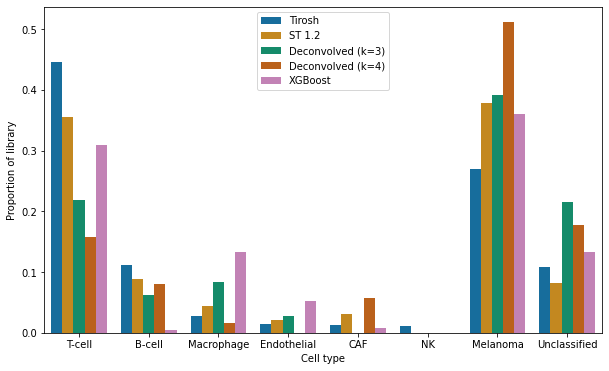

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.barplot(data=composition, y='fraction',
              x="inferred_cell_type", order=cell_types,
              hue="sampleID", hue_order=samples, ax=ax)
ax.set_xlabel("Cell type")
ax.set_ylabel("Proportion of library")
ax.legend(frameon=True, loc='upper center')

## Prediction scores

Prediction scores by cell type and sample.

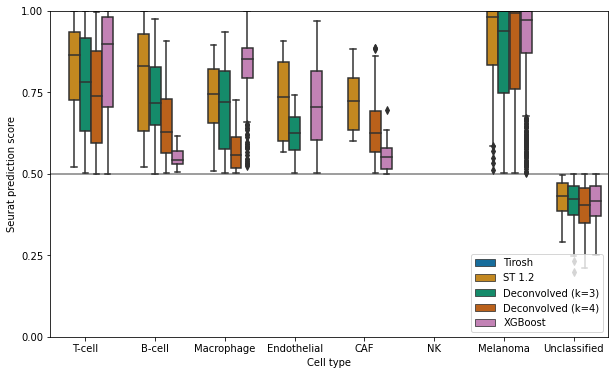

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = sns.boxplot(data=spots, x="inferred_cell_type", y="score", hue='sampleID', order=cell_types, ax=ax)
# ax = sns.swarmplot(data=spots, x="cell_type_inferred", y="score", hue='sampleID', split=True, order=cell_types, ax=ax, edgecolor='k', linewidth=1)
ax.axhline(0.5, c='gray', zorder=0)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.set_xlabel("Cell type")
ax.set_ylabel("Seurat prediction score")
ax.legend(frameon=True, loc='lower right')

## Unclassified spots

First, pull out unclassified spots from spatial samples. (Unclassified meaning Seurat prediction score <0.5)

In [149]:
ST = spots.loc[spots.sampleID != 'Tirosh']
unclassified = ST.loc[ST.score < 0.5].copy()

cols = [c for c in unclassified.columns if c.startswith('prediction.score') and c != 'prediction.score.max']

Identify second highest scoring cell type

In [150]:
def second_choice(row):
    second = row[cols].sort_values(ascending=False).index[1]
    second = '-'.join(second.split('.')[2:])
    return second

unclassified['second_choice'] = unclassified.apply(second_choice, axis=1)
unclassified['second_choice_score'] = unclassified.apply(lambda row: row[cols].sort_values(ascending=False).iloc[1], axis=1)

In [208]:
for sample in samples[1:]:
    df = unclassified.loc[unclassified.sampleID == sample].copy()
    df = df.rename(columns={'predicted.id': 'first_choice', 'prediction.score.max': 'first_choice_score'})
    df.to_csv(f'results/alignment/{sample}.unclassified.csv', index=False, header=True)

Make pivot table of first vs second choice cell types

### First vs second choice cell types

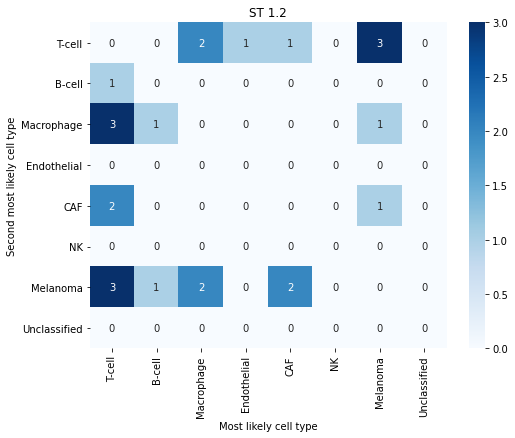

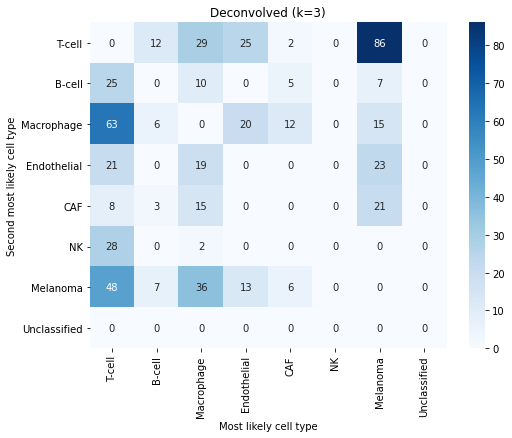

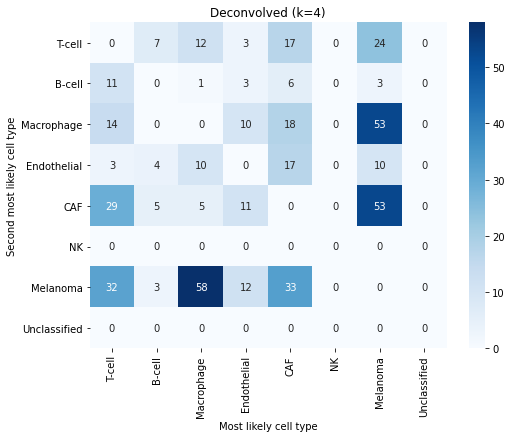

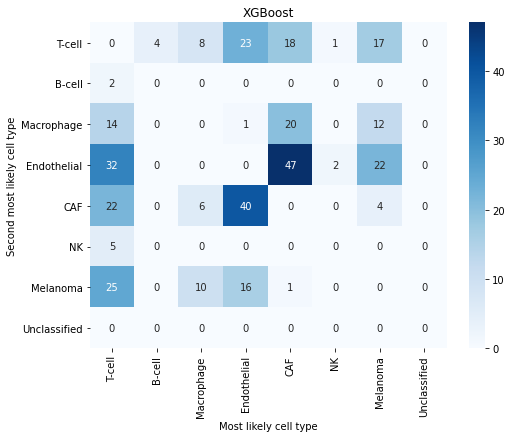

In [153]:
for sample in samples[1:]:
    hmap = dfs[sample]
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.heatmap(data=hmap, 
                cmap='Blues', vmin=0,
                annot=True, fmt='d',
                ax=ax)
    ax.set_title(sample)
    ax.set_xlabel('Most likely cell type')
    ax.set_ylabel('Second most likely cell type')

### First vs second choice cell type scores

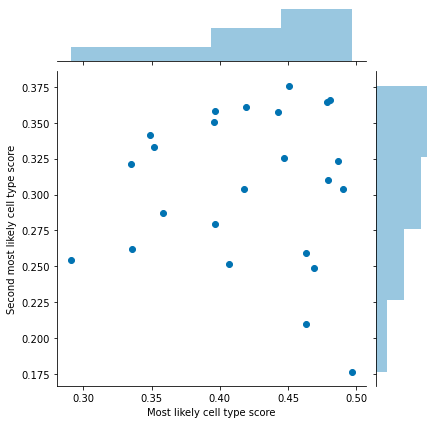

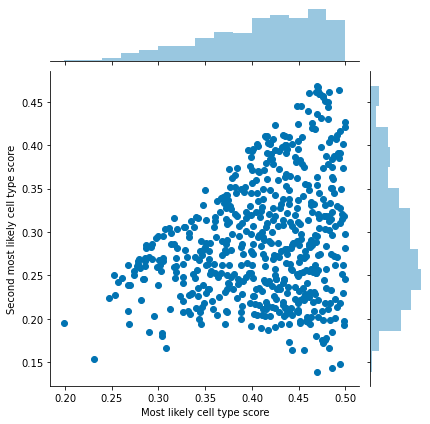

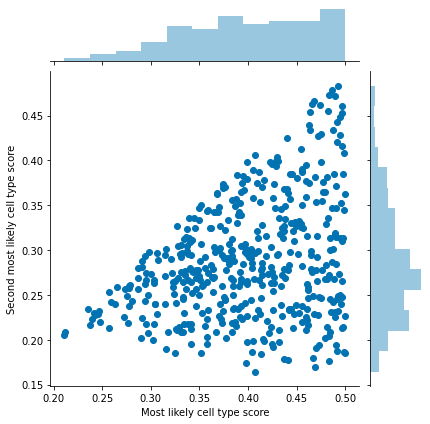

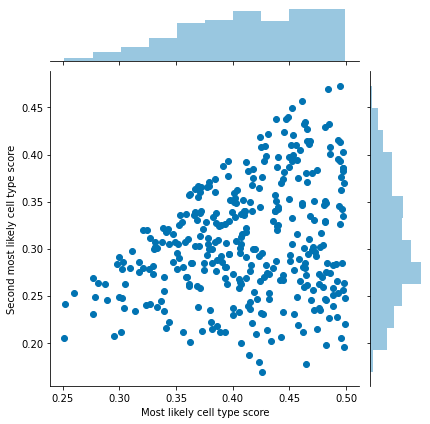

In [154]:
for sample in samples[1:]:
    df = unclassified.loc[unclassified.sampleID == sample]
    
#     fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    g = sns.jointplot(data=df, 
                x='prediction.score.max', y='second_choice_score')
#     ax.set_title(sample)
    g.set_axis_labels('Most likely cell type score', 'Second most likely cell type score')

## Comparing to parents

In [201]:
from sklearn.metrics import adjusted_rand_score

For each deconvolution strategy, compare the inferred cell types of each subspot to the inferred cell type of its parent. 

Plot a heatmap of counts and fractions of (subspot, parent spot) cell type pairings, and compute ARI of subspot assignments using parent assignments as truth.

0.29293617564662555
0.2630259356409572
0.2992314757716125


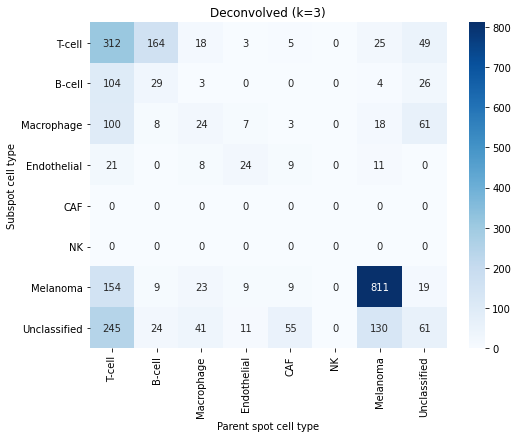

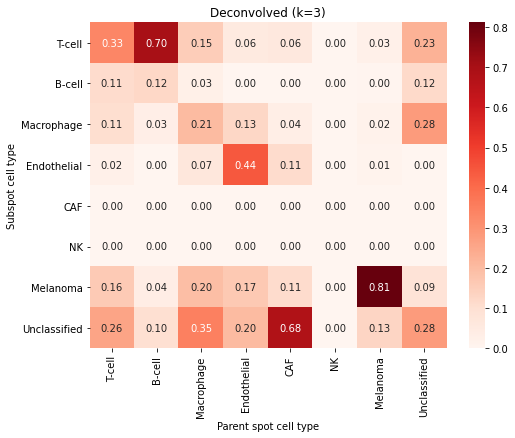

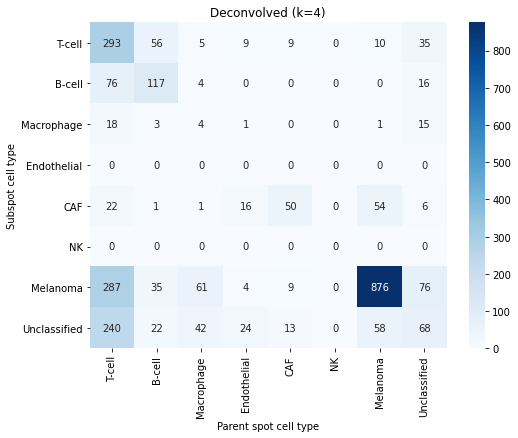

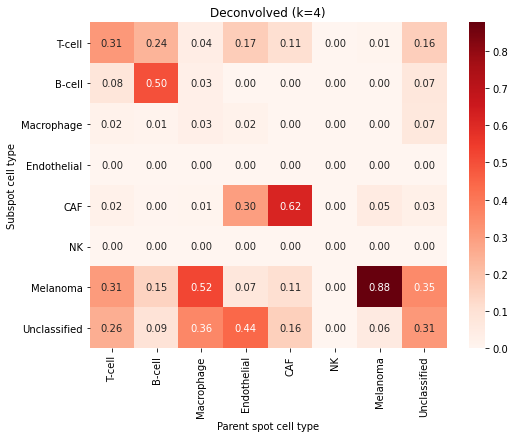

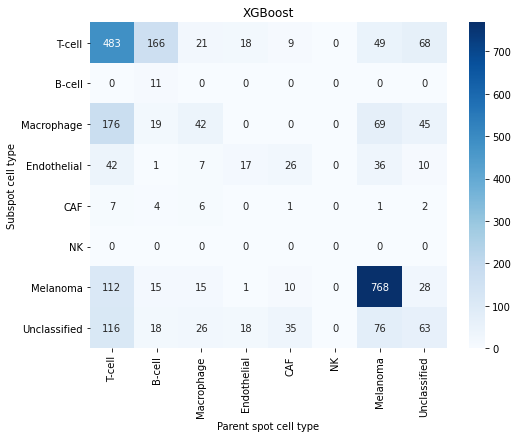

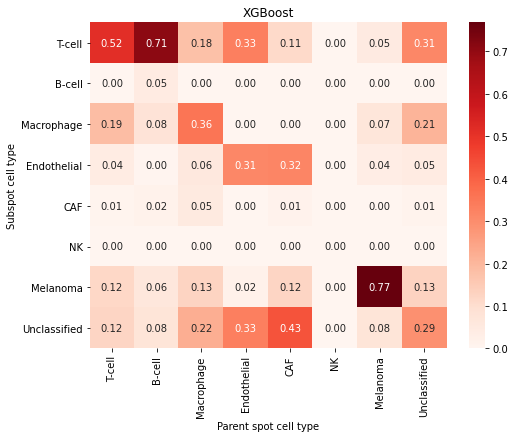

In [225]:
deconv = ST.loc[ST.sampleID != 'ST 1.2'].copy()
spots = ST.loc[ST.sampleID == 'ST 1.2'].copy()

cols = 'Spot inferred_cell_type prediction.score.max'.split()

for sample in samples[2:]:
    df = deconv.loc[deconv.sampleID == sample].reset_index(drop=True)
    df.index = df.index.rename('subspot_index')
    df = df.reset_index()
    df['spot_index'] = df.subspot_index.mod(293)
    
    df = pd.merge(df[['spot_index'] + cols], spots[cols], left_on='spot_index', right_index=True, how='left', suffixes=('_subspot', '_parent'))
    print(adjusted_rand_score(df.inferred_cell_type_parent, df.inferred_cell_type_subspot))

    hmap = df.pivot_table(index='inferred_cell_type_subspot', columns='inferred_cell_type_parent', values='spot_index', aggfunc='count')
    hmap = hmap.reindex(index=cell_types, columns=cell_types).fillna(0).astype(int)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax = sns.heatmap(hmap,
                annot=True, fmt='d',
                cmap='Blues', ax=ax)
    ax.set_title(sample)
    ax.set_xlabel('Parent spot cell type')
    ax.set_ylabel('Subspot cell type')
    
    frac = (hmap / hmap.sum(axis=0)).fillna(0)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax = sns.heatmap(frac,
                annot=True, fmt='.02f',
                cmap='Reds', ax=ax)
    ax.set_title(sample)
    ax.set_xlabel('Parent spot cell type')
    ax.set_ylabel('Subspot cell type')